In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pylab as plt
import arviz as az
from sklearn.metrics import mean_squared_error

## Data prep

In [2]:
df = pd.read_csv('wikidata.csv', index_col=0)
df['date_'] = pd.to_datetime(df.date,unit='D', origin='1970-1-1')
df = df.set_index('date_')
df = df.drop(['date', 'article', 'language'], 1)
df.head()

,views
date_,
2007-12-10,85.0
2007-12-11,93.0
2007-12-12,76.0
2007-12-13,86.0
2007-12-14,62.0


In [3]:
# drop < 2012 years
df_2012 = df[df.index.year >= 2012]
# add day-1 feature
df_2012['views_1'] = [np.nan] + df_2012.views[:-1].tolist()

# add "minus 1 week" feature
df_2012['views_week'] = [np.nan]*7 + df_2012.views[:-7].tolist()

# add previous year features
df_2013 = df_2012.set_index(df_2012.index + pd.DateOffset(years=1))[['views']]
df_2013 = df_2013[df_2013.index.year < 2022]
df_2013.columns = ['views_year']
# complete adding
df_complete = df_2012.join(df_2013)
df_complete = df_complete[df_complete.index.year > 2012]

# approximate 29th of februare linearly 
df_complete_int = df_complete.interpolate(method='linear')

#  test/train sampling (test is 2021 year)
df_train, df_test = df_complete_int[df_complete_int.index.year < 2021], df_complete_int[df_complete_int.index.year >= 2021]

<ipython-input-3-50b1a764fcaa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2012['views_1'] = [np.nan] + df_2012.views[:-1].tolist()
<ipython-input-3-50b1a764fcaa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2012['views_week'] = [np.nan]*7 + df_2012.views[:-7].tolist()


In [4]:
df_train.head()

,views,views_1,views_week,views_year
date_,,,,
2013-01-01,284.0,370.0,246.0,148.0
2013-01-02,523.0,284.0,0.0,230.0
2013-01-03,520.0,523.0,366.0,309.0
2013-01-04,533.0,520.0,401.0,346.0
2013-01-05,700.0,533.0,356.0,341.0


In [5]:
df_test.head()

,views,views_1,views_week,views_year
date_,,,,
2021-01-01,390.0,500.0,414.0,423.0
2021-01-02,622.0,390.0,470.0,663.0
2021-01-03,652.0,622.0,554.0,662.0
2021-01-04,661.0,652.0,554.0,440.0
2021-01-05,705.0,661.0,554.0,565.0


## Modelling

In [6]:
def plot_train(year, posterior_pred, plot='train.png'):
    plt.figure(figsize=(20,5))
    plt.plot(df_train.views[df_train.index.year == year].values, label='True', c='red')
    up = np.quantile(posterior_pred['y_hat'], 0.975, axis=0)[df_train.index.year == 2017]
    low = np.quantile(posterior_pred['y_hat'], 0.025, axis=0)[df_train.index.year == 2017]
    plt.fill_between(range(len(up)), low, up, color='blue', alpha=.15, label='95% prediction credible interval', )
    rmse = np.sqrt(mean_squared_error(posterior_pred['y_hat'].mean(0), df_train.views))
    plt.title(f'{year} year, total RMSE (all years) = {rmse:.2f}')
    print(f'RMSE = {rmse:.2f}')
    plt.legend()
    plt.savefig(plot)
    plt.show()

def plot_test(pred, plot='test.png'):
    rmse = np.sqrt(mean_squared_error(pred['y_hat'].mean(0), df_test.views))
    plt.figure(figsize=(20,5))
    plt.plot(df_test.views.values, label='True', c='red')
    up = np.quantile(pred['y_hat'], 0.975, axis=0)
    low = np.quantile(pred['y_hat'], 0.025, axis=0)
    plt.fill_between(range(len(up)), low, up, color='blue', alpha=.15, label='95% prediction credible interval')
    print(f'RMSE = {rmse:.2f}')
    plt.title(f'RMSE = {rmse:.2f}')
    plt.legend()
    plt.savefig(plot)
    plt.show()

def report_model(trace):
    for name in trace.varnames:
        print(name, end='\t')
    print()
    for name in trace.varnames:
        print(f'{trace[name].mean():.2f}', end='\t')
    print()
    
def predict(model, trace, data, y):
    with model:
        for i, x in enumerate(data):
            pm.set_data(
                {f"features{i+1}": x.values.flatten()}
            )

        pm.set_data(
            { "observed": y.values.flatten()}
        )
        pred = pm.fast_sample_posterior_predictive(trace)
    return pred

In [7]:
data = [df_train.views_1, df_train.views_week, df_train.views_year]
y = df_train.views

with pm.Model() as model:
    # y = b_1*x_1 + ... + b0
    b0 = pm.Normal('b0', mu=0, sigma=1)
    bs = []
    xs = []
    for i, x in enumerate(data):
        bs.append(pm.Normal(f'b{i+1}', mu=0., sigma=1))
        xs.append(pm.Data(f'features{i+1}', x.values.flatten()))

    y_ = pm.Data('observed', y.values.flatten())
    sigma = pm.HalfNormal("sigma", sigma=250)
    
    # the model
    mu = b0
    for i in range(len(xs)):
        mu += xs[i] * bs[i]

    y_hat = pm.Normal(
      "y_hat",
      mu=mu,
      sigma=sigma,
      observed=y_,
    )
    
    # sometimes it is called trace
    posterior = pm.sample(draws=2000, tune=3000)
    # predict train
    posterior_pred = pm.fast_sample_posterior_predictive(posterior)

<ipython-input-7-8ac10057ac4e>:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  posterior = pm.sample(draws=2000, tune=3000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/ailin/opt/miniconda3/envs/trips/lib/python3.9/site-packages/aesara/graph/fg.py:525: UserWarning: Variable Elemwise{mul,no_inplace}.0 cannot be replaced; it isn't in the FunctionGraph
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b3, b2, b1, b0]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.6542329526976154, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
az.summary(posterior, )

/Users/ailin/opt/miniconda3/envs/trips/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,1.079,0.989,-0.735,2.954,0.014,0.012,4851.0,3885.0,1.0
b1,0.372,0.014,0.346,0.399,0.000,0.000,4196.0,3302.0,1.0
b2,0.602,0.013,0.577,0.627,0.000,0.000,4090.0,3569.0,1.0
b3,0.012,0.007,-0.001,0.027,0.000,0.000,5538.0,4497.0,1.0
sigma,143.382,1.898,139.872,147.044,0.026,0.019,5180.0,3107.0,1.0


b0	b1	b2	b3	sigma_log__	sigma	
1.08	0.37	0.60	0.01	4.97	143.38	
RMSE = 143.26


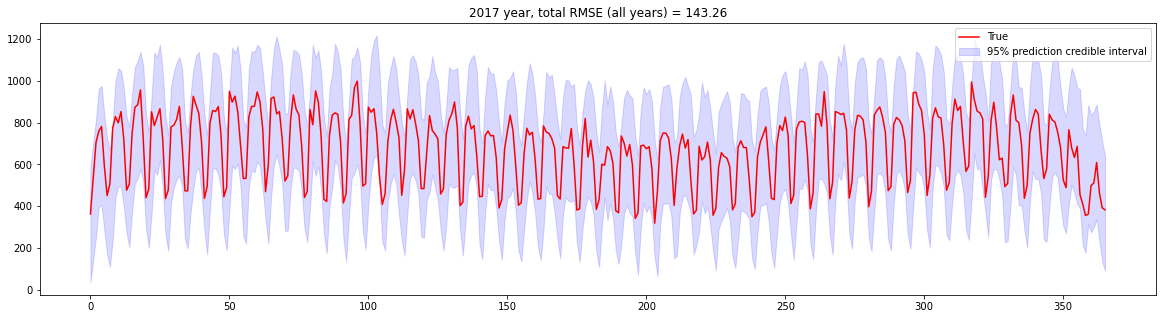

In [9]:
# plot train
report_model(posterior)
plot_train(2017, posterior_pred, 'train.png')

RMSE = 89.39


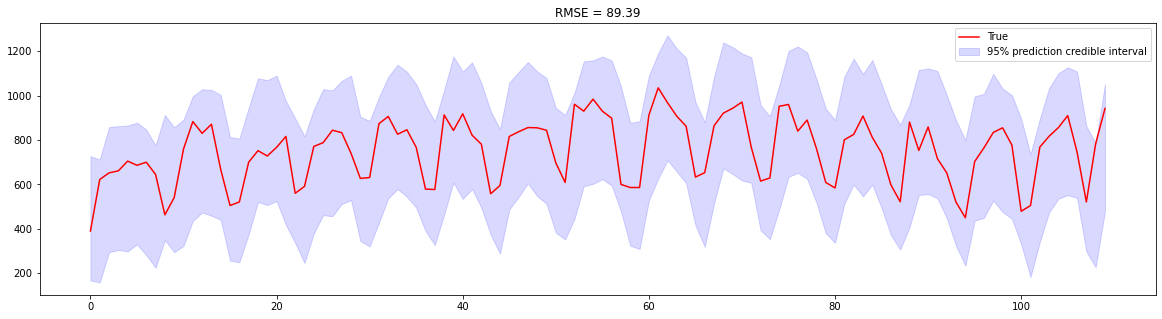

In [10]:
pred_1 = predict(model, posterior, [df_test.views_1, df_test.views_week, df_test.views_year], df_test.views)
plot_test(pred_1, 'test.png')

In [ ]:
## Gradient-Based Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression
lr3 = LinearRegression()
lr3.fit(df_train[['views_1', 'views_week', 'views_year']].values, df_train.views.values)
print('b_i:', lr3.coef_, 'intercept:', lr3.intercept_)
print('test RMSE:', np.sqrt(mean_squared_error(df_test.views.values.reshape(-1,1), lr3.predict(df_test[['views_1', 'views_week','views_year']].values))))
print('train RMSE:')
lrpred_1_1_1 = lr3.predict(df_train[['views_1', 'views_week','views_year']].values)
np.sqrt(mean_squared_error(df_train.views.values.reshape(-1,1), lrpred_1_1_1))

b_i: [ 0.31801667  0.54246413 -0.00239435] intercept: 86.00274768364557
test RMSE: 90.98196017267334
train RMSE:


140.93875472472192